In [238]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler


mpl.rcParams['figure.figsize'] = (20, 5)
mpl.rcParams['axes.grid'] = False
plt.style.use('ggplot')

In [239]:
# creating a dataframe from the csv file
df = pd.DataFrame(pd.read_csv('../output/zero4_outputs.csv'))
df = df.drop([df.columns[0]], axis='columns') 
df = df.iloc[:,:-3]
df.reset_index(drop=True, inplace=True)
  
# Change UTC Time to CST Time 
from datetime import datetime

CST_time_list = []
for time in df['Time'].to_list():
    CST_time_list.append(datetime.fromtimestamp(time))

df['Time'] = pd.DataFrame(CST_time_list)

# Date Time: Minutes Seconds
# df.index = pd.to_datetime(df['Time'], format='%d.%m.%Y %H:%M:%S')
date_time = df['Time'].dt.strftime('%M %S')

# checking our dataframe once again
df.head()

,Time,Subcar_0,Subcar_1,Subcar_2,Subcar_3,Subcar_4,Subcar_5,Subcar_6,Subcar_7,Subcar_8,...,Subcar_49,Subcar_50,Subcar_51,Subcar_52,Subcar_53,Subcar_54,Subcar_55,Subcar_56,Subcar_57,Subcar_58
0,2022-01-08 08:35:42,5499.938181,7461.867126,6230.129694,8741.921642,297.127919,327.200244,362.527240,353.411941,351.432782,...,575.782077,520.239368,471.936436,437.649403,412.093436,393.782935,396.807258,398.600050,399.450873,405.544079
1,2022-01-08 08:35:43,5499.938181,7461.867126,6230.129694,8741.921642,350.910245,340.565706,338.013313,332.434956,327.232333,...,455.247186,423.709806,390.858030,367.766230,339.484904,339.087010,343.083080,343.739727,346.943800,351.039884
2,2022-01-08 08:35:44,5499.938181,7461.867126,6230.129694,8741.921642,357.572370,389.307077,421.911128,424.001179,447.754397,...,672.899695,599.141052,524.108767,466.309983,418.119600,397.935924,387.985824,371.260017,354.983098,338.710791
3,2022-01-08 08:35:45,5499.938181,7461.867126,6230.129694,8741.921642,507.385455,518.653063,533.348854,545.424605,542.492396,...,610.351538,538.108725,508.141712,459.243944,413.706418,406.503382,392.998728,389.802514,381.072172,390.508643
4,2022-01-08 08:35:46,5499.938181,7461.867126,6230.129694,8741.921642,379.117396,397.553770,415.226444,450.480854,445.583887,...,788.428817,729.188590,698.148981,653.314626,626.906692,633.941638,639.366092,651.254942,668.481862,671.060355


<AxesSubplot:>

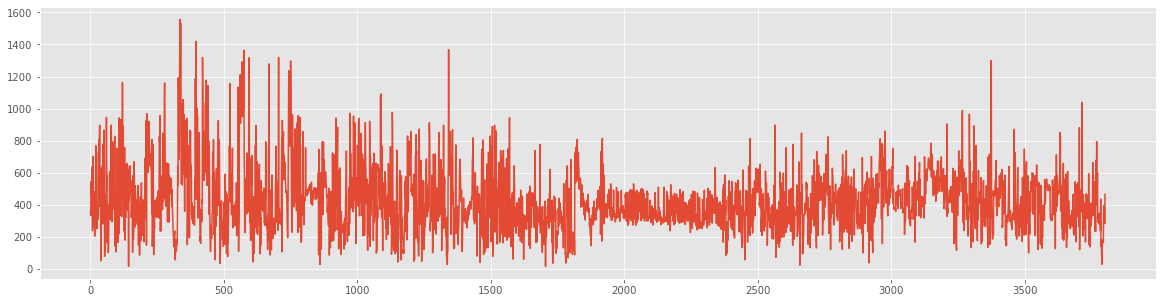

In [240]:
temp = df['Subcar_7']
temp.plot()

In [241]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i + 5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)

In [242]:
WINDOW_SIZE = 32
X, y = df_to_X_y(temp, WINDOW_SIZE)
X.shape, y.shape

((3770, 5, 1), (3770,))

In [243]:
# data partitioning
x_train, y_train = X[:2000], y[:2000]
x_test, y_test = X[700:750], y[700:750]
x_val, y_val = X[750:], y[750:]

# train data normalisation
x_train_mean = x_train.mean()
y_train_mean = y_train.mean()

x_train_std = x_train.std()
y_train_std = y_train.std()

x_train = (x_train - x_train_mean) / x_train_std

# test validation data normalisation
x_test_mean = x_test.mean()
y_test_mean = y_test.mean()

x_test_std = x_test.std()
y_test_std = y_train.std()

x_test = (x_test - x_test_mean) / x_test_std

# validation data normalisation
x_val_mean = x_val.mean()
y_val_mean = y_val.mean()

x_val_std = x_val.std()
y_val_std = y_val.std()

x_val = (x_val - x_val_mean) / x_val_std

print('x_train set:', x_train.shape)
print('y_train set:', y_train.shape)
print('x_test set:', x_test.shape)
print('y_test:', y_test.shape)
print('x_val set:', x_val.shape)
print('y_val set:', y_val.shape)

x_train set: (2000, 5, 1)
y_train set: (2000,)
x_test set: (50, 5, 1)
y_test: (50,)
x_val set: (3020, 5, 1)
y_val set: (3020,)


In [244]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

In [245]:
model_1 = Sequential()
model_1.add(InputLayer((5, 1)))
model_1.add(Conv1D(64, kernel_size=2))
model_1.add(Conv1D(32, kernel_size=2))
model_1.add(Flatten())
model_1.add(Dense(8, 'relu'))
model_1.add(Dense(1, 'linear'))

model_1.summary()


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, 4, 64)             192       
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 3, 32)             4128      
_________________________________________________________________
flatten_13 (Flatten)         (None, 96)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 776       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 9         
Total params: 5,105
Trainable params: 5,105
Non-trainable params: 0
_________________________________________________________________


In [246]:
cp = ModelCheckpoint('../save/model6/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
model_1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[MeanAbsoluteError()])
val_performance = {}
performance = {}


In [247]:
model_1.fit(x_train, y_train, validation_data=(x_val, y_val),  epochs=100, callbacks=[early_stopping, cp])

Epoch 1/100
63/63 [==============================] - 1s 11ms/step - loss: 132814.1250 - mean_absolute_error: 281.3259 - val_loss: 29194.9961 - val_mean_absolute_error: 123.5719
Epoch 2/100
63/63 [==============================] - 1s 10ms/step - loss: 40803.0234 - mean_absolute_error: 150.0956 - val_loss: 26752.5645 - val_mean_absolute_error: 121.4173
Epoch 3/100
63/63 [==============================] - 0s 1ms/step - loss: 38435.5156 - mean_absolute_error: 144.7655 - val_loss: 29299.1992 - val_mean_absolute_error: 128.3276
Epoch 4/100
63/63 [==============================] - 1s 10ms/step - loss: 37909.5039 - mean_absolute_error: 141.5237 - val_loss: 26141.8301 - val_mean_absolute_error: 115.6653
Epoch 5/100
63/63 [==============================] - 1s 10ms/step - loss: 38309.7930 - mean_absolute_error: 142.4748 - val_loss: 23529.6484 - val_mean_absolute_error: 111.2097
Epoch 6/100
63/63 [==============================] - 1s 9ms/step - loss: 38053.3789 - mean_absolute_error: 142.6773 - va

In [ ]:
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


In [248]:
from tensorflow.keras.models import load_model
model1 = load_model('../save/model6/')

In [249]:
test_predictions1 = model1.predict(x_test).flatten()
test_results1 = pd.DataFrame(data={'Test predictions': test_predictions1, 'Actuals': y_test})
test_results1

,Test predictions,Actuals
0,387.404999,1318.891959
1,621.449646,427.907700
2,418.510651,308.974109
3,346.017426,375.431752
4,317.443115,315.995253
5,302.190460,323.487249
6,290.344543,281.128085
7,273.504333,346.161812
8,290.552094,294.266886
9,277.278442,291.756748


In [251]:
mape(test_predictions1, y_test)


54.523072482339686

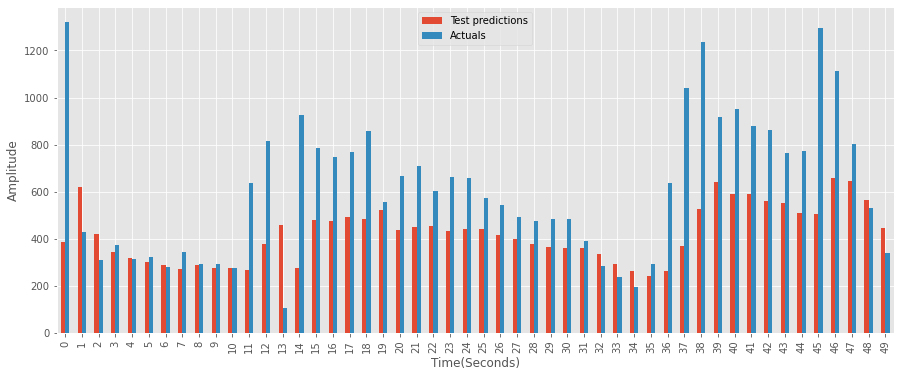

In [252]:
fig,ax = plt.subplots(figsize=(15,6))
test_results1.plot(kind='bar',ax=ax)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

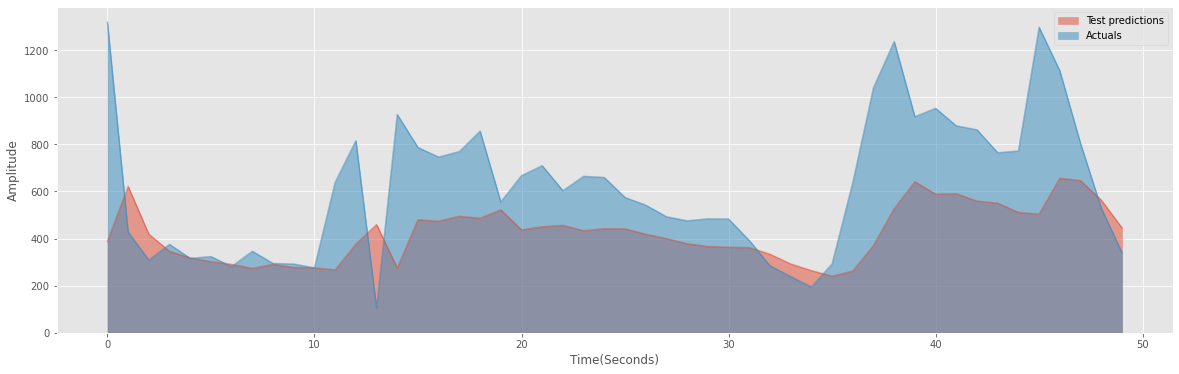

In [253]:
fig,ax = plt.subplots(figsize=(20,6))
test_results1.plot(kind='area',ax=ax,stacked=False)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

Text(0, 0.5, 'Amplitude')

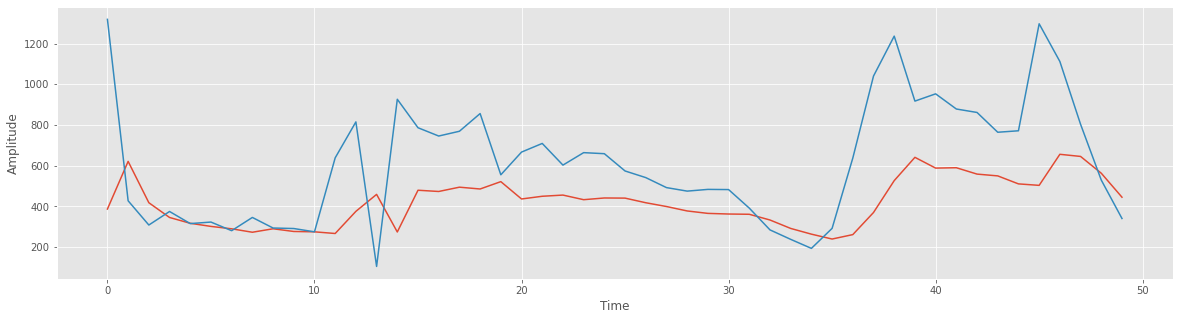

In [254]:
plt.plot(test_results1['Test predictions'])
plt.plot(test_results1['Actuals'])
plt.xlabel("Time")
plt.ylabel("Amplitude")